## はじめに

** チャートパターンをディープラーニングで判定し、値動きを予測したい**

そんな野望から、検討を行うことにした。

今回は、現在価格と将来価格の関係性について調査したので報告する。


## 検討方法

具体的な検討方針を以下に述べる。

   - データベース中の期間からランダムに現在時刻を設定
   - 現在時刻までの一定期間の値動きを抽出 (ds1)
   - 現在時刻の直近の終値から基準値を算出（現在価格）
   - 現在時刻から一定期間離れた時刻を将来時刻と設定
   - 将来時刻までの一定期間の値動きを抽出 (ds2)
   - 将来時刻における始値を算出（将来価格）
   - 将来価格と現在価格の差の絶対値を算出（価格差）
   - 将来価格と現在価格の関係を算出(価格変化率）
   - 価格変化率の大きさと発生回数いから発生率を算出
   - 価格変化率の絶対値ががある一定以上より大きいものを抽出 (alpha) 
   - リスクリ・リワード比 (Risk Reward Ratio) を算出
      + 過去一定時間の反対極値に対する価格差の比率
   - alpha のうち、リスク･リワード比が一定以上のものを抽出 (alpha2)
   - alpha2 データセットに対して ds1 と ds2 を可視化


なお、今回の検討では、以下の条件とした。

   - BitMEX における BTC/USD 5分足で検討
   - データセット期間 2017/1/1 〜 2019/1/12 
   - 過去180分のデータを抽出
   - 基準価格は直近の終値を使用
   - 将来価格は、現在から1時間後の始値
   - 価格変化率は 3.5%
   - Risk Reward Ratio の基準は 2



## おわりに

将来価格が現在価格に対して優位に変化する確率はおよそ数パーセント程度であることが分かった。

リスク･リワード比を考慮すると、およそ1パーセント程度。

問題は、この優位性をどの程度の精度で判定できるかだ。

今回の結果を踏まえて、学習用のデータセットを作成する予定。


## 付録

以下に、コードと分析結果を示す


### 各種初期設定

In [4]:
from datetime import datetime
from time import sleep
import requests
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from mpl_finance import candlestick2_ohlc, volume_overlay
%matplotlib inline

### データベースから5分足データを取得

In [6]:
import mysql.connector

cnt = mysql.connector.connect(
    host='localhost',
    port='3306',
    db='bitmex',
    user='bitmex',
    password='bitmex',
    charset='utf8'
)

cur = cnt.cursor()

sql = "select t, o, h, l, c, v from xbtusd_5m order by t asc"
cur.execute(sql)
data = cur.fetchall()

### Pandas に変換

In [7]:
df = pd.DataFrame(data)
df.columns = ["Time", "Open", "High", "Low", "Close", "Volume"]
df[0:5]

,Time,Open,High,Low,Close,Volume
0,1483228800,968.3,968.8,966.7,967.0,119555
1,1483229100,967.0,967.0,966.9,966.9,26962
2,1483229400,966.9,966.9,964.9,964.9,124137
3,1483229700,964.9,965.0,964.8,964.8,3001
4,1483230000,964.8,964.8,964.8,964.8,0


### 各種パラメータ

In [8]:
bar_type   = 5              # 5分足
time_frame = 180            # 考慮する現在価格の範囲 (分)
frame_size = int(time_frame / bar_type)  # データ数
bars_prev_base_price = 1    # 判断基準となる価格を算出する足の数
bars_ahead_prediction = 12  # 価格を予測するバーが現在からどの程度離れているか
deviation_criteria = 5      # 価格の変動優位性を考慮する基準 (%)
bars_risk_rewards_calc = 12 # リスクリワードを計算する時に用いる過去バーの数

### 一定時間内の値動きと将来価格の関係性について集計

In [9]:
run_times = 10000
results = []
for i in range(run_times):

    # 最初のデータ位置をランダムに決定
    idx = random.randint(0,len(df)-frame_size-bars_ahead_prediction)
    idx2 = idx + frame_size
    idx3 = idx2 + bars_ahead_prediction
    ds = df[idx:idx2]    # 現在までの価格情報
    ds2 = df[idx:idx3]   # 未来も含む価格情報
    
    base_prices = df[idx2-bars_prev_base_price:idx2]["Close"].values
    base_price = np.mean( base_prices )               # 変化前価格の基準値
    future_price = df[idx3-1:idx3]["Open"].values[0]  # 将来価格
    diff = future_price - base_price                  # 価格変化 (USD)
    deviation = diff / base_price * 100.0             # 価格変化率 (%)
    
    # リスク・リワード比の計算
    rds = df[idx2-bars_risk_rewards_calc:idx2]
    highs = rds['High'].values
    lows = rds['Low'].values
    highest = max(highs)
    lowest = min(lows)
    if deviation > 0:
        risk = base_price - lowest
        reward = future_price - base_price
    else:
        risk = highest - base_price
        reward = base_price - future_price

    rs_ratio = reward / risk if risk > 0.0 else 0.0

    results.append( (deviation, abs(deviation), diff, rs_ratio,
                     base_price, future_price, idx, idx2, idx3) )

In [10]:
ret = pd.DataFrame(results)
ret.columns = ["Dev", "DevA", "Diff", "RRR", "Base", "Future",
               "idx", "idx2", "idx3"]

ここで各カラムの意味は次の通り
 - Dev: 将来価格が現在に比べてどの程度変化したか (%)
 - DevA: Dev の絶対値
 - Diff: 将来価格の現在価格からの変化 (USD)
 - RRR: Risk Reward Ratio
 - Baes: 現在価格
 - Future: 将来価格
 - idx: 過去データの開始インデックス
 - idx2: 将来価格データの開始インデックス
 - idx3: 将来価格算出のためのインデックス (idx3-1のデータを使用）

In [11]:
ret[0:5]

,Dev,DevA,Diff,RRR,Base,Future,idx,idx2,idx3
0,-0.101682,0.101682,-6.5,2.600000,6392.5,6386.0,188851,188887,188899
1,-0.505546,0.505546,-9.8,6.533333,1938.5,1928.7,39808,39844,39856
2,-0.075088,0.075088,-4.5,0.166667,5993.0,5988.5,169935,169971,169983
3,0.164048,0.164048,1.9,0.441860,1158.2,1160.1,27433,27469,27481
4,0.075772,0.075772,8.0,0.043011,10558.0,10566.0,119954,119990,120002


### 将来価格の変化量と発生回数

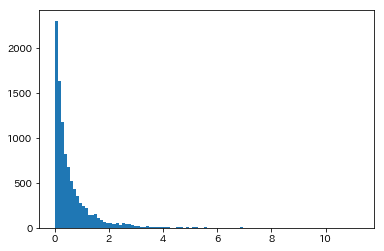

In [14]:
devs = ret["DevA"]   # 変化量の絶対値の度数分布
hist_fig = plt.hist(devs, bins=100)

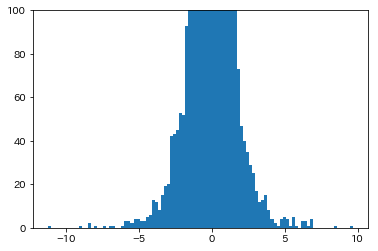

In [15]:
devs = ret["Dev"]   # 変化量の度数分布（拡大図）
plt.ylim(0,100)
hist_fig = plt.hist(devs, bins=100)  # 拡大図

### 将来価格の変化量と発生確率

In [16]:
freqs = []
details = []
dev_targets = list(np.arange(0.5, 5.0, 0.25))
for dev in dev_targets:
    occured = len(ret[ret["DevA"]>dev])
    rate = occured / run_times * 100
    details.append( [dev, occured, rate] )
    freqs.append(rate)

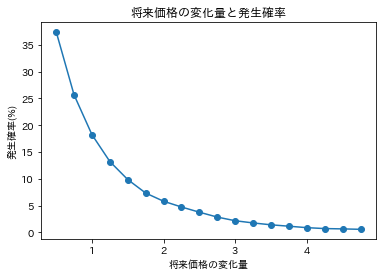

In [20]:
plt.title("将来価格の変化量と発生確率")
plt.xlabel("将来価格の変化量")
plt.ylabel("発生確率(%)")
rate_fig = plt.plot(dev_targets, freqs, marker="o")

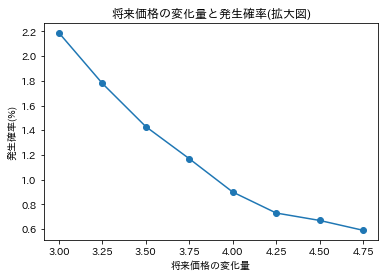

In [21]:
plt.title("将来価格の変化量と発生確率(拡大図)")
plt.xlabel("将来価格の変化量")
plt.ylabel("発生確率(%)")
rate_fig2 = plt.plot(dev_targets[10:], freqs[10:], marker="o")

価格変化の絶対値が 3.5% 以上で、リスク･リワード比が2以上の場合を抽出

In [30]:
alpha = ret[ ret["DevA"]>3.5 ]
alpha2 = alpha[ alpha["RRR"] > 2]
print( f'件数: {len(alpha2)}' )
alpha2[0:5]

件数: 105


,Dev,DevA,Diff,RRR,Base,Future,idx,idx2,idx3
128,-4.928832,4.928832,-722.0,2.359477,14648.5,13926.5,102552,102588,102600
140,4.844405,4.844405,87.8,36.583333,1812.4,1900.2,56569,56605,56617
147,-4.126944,4.126944,-164.5,2.164474,3986.0,3821.5,208192,208228,208240
304,5.271232,5.271232,123.7,6.510526,2346.7,2470.4,57697,57733,57745
358,-4.233871,4.233871,-756.0,2.930233,17856.0,17100.0,101588,101624,101636


### 関数定義

In [5]:
# UNIX時間から文字列に変換
def t2s(the_time):
    return datetime.fromtimestamp(int(the_time)).strftime('%Y/%m/%d %H:%M')

In [31]:
def make_plot(ds, mode="base", label=True):
    # ローソク足をプロット
    wsize = frame_size if mode=="base" else frame_size + bars_ahead_prediction
    fig = plt.figure(figsize=(wsize/6, 4))
    ax = plt.subplot(1, 1, 1)

    candlestick2_ohlc(ax, ds["Open"], ds["High"], ds["Low"], ds["Close"], width=0.9, colorup="#0000ff", colordown="#ff0000", alpha=1.0)
    #ax.set_xticklabels([(df.index[int(x)].strftime("%Y/%M/%D") if x < df.shape[0] else x) for x in ax.get_xticks()], rotation=90)
    ax.set_xlim([0, ds.shape[0]]) # 横軸の範囲はデータの個数(df.shape[0]個)までに変更しておく
    #ax.set_ylabel("Price")

    # ローソク足を上側 1/2 に収める
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom - (top - bottom) , top)


    # 出来高のチャートをプロット
    ax2 = ax.twinx()
    volume_overlay(ax2, ds["Open"], ds["Close"], ds["Volume"], width=1, colorup="#00ff00", colordown="#00ff00", alpha=1.0)
    ax2.set_xlim([0, ds.shape[0]])

    # 出来高チャートは下側 1/3 に収める
    ax2.set_ylim([0, ds["Volume"].max() * 3])
    #ax2.set_ylabel("Volume")
    
    if not label:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.tick_params(bottom=False, left=False, right=False, top=False)
        ax2.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax2.tick_params(bottom=False, left=False, right=False, top=False)
       

In [32]:
def plot_comp(ret):
    idx = ret["idx"].values[0]
    idx2 = ret["idx2"].values[0]
    idx3 = ret["idx3"].values[0]
    ds = df[idx:idx2]
    ds2 = df[idx:idx3]
    make_plot(ds, mode="base")
    make_plot(ds2, mode="prediction")

### チャートの作成
現在時刻までのチャート（上）と将来時刻までのチャート（下）を10セット描画

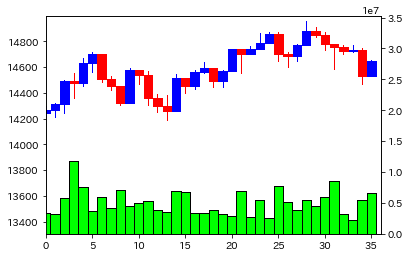

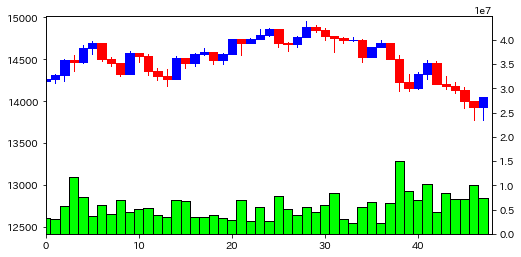

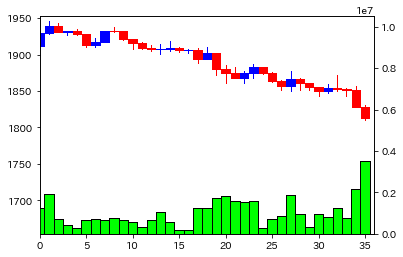

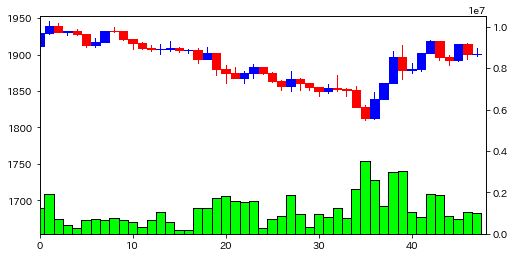

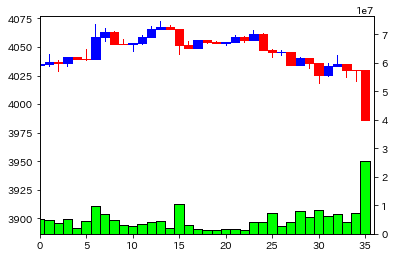

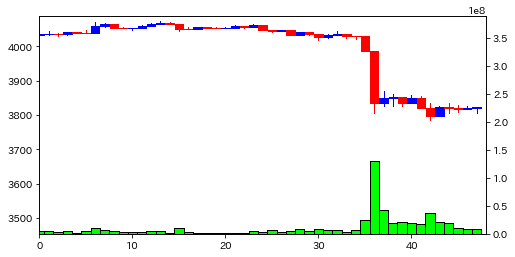

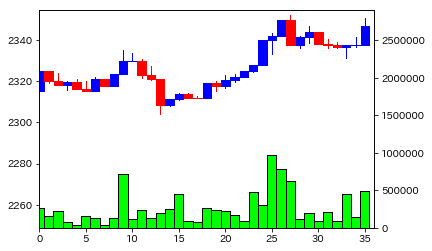

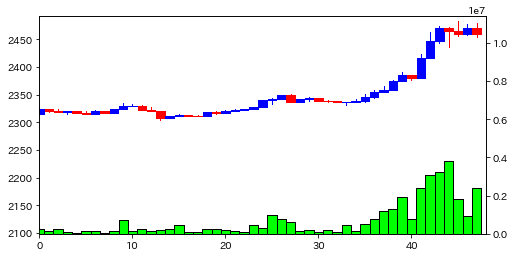

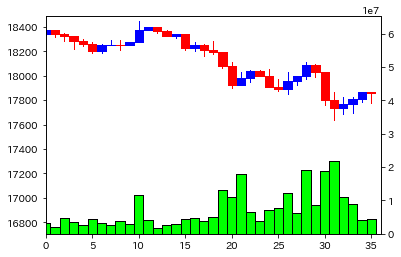

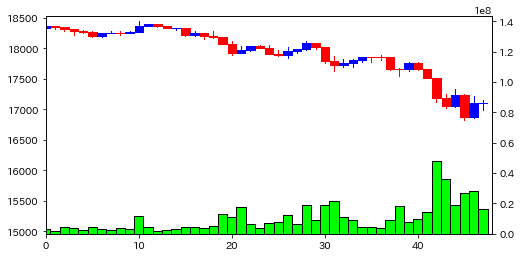

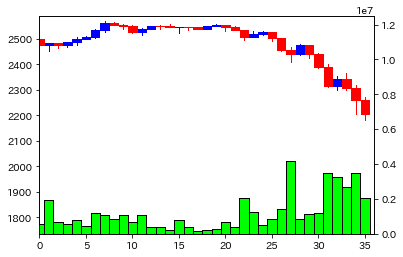

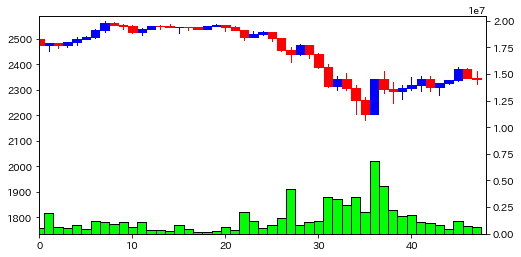

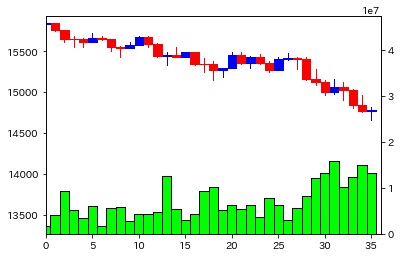

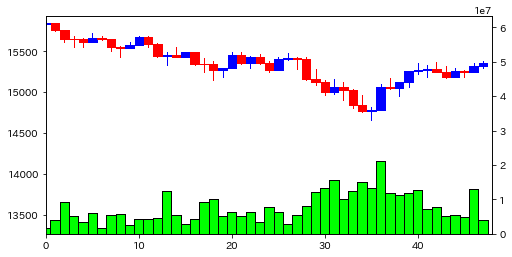

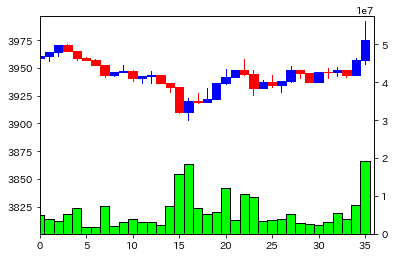

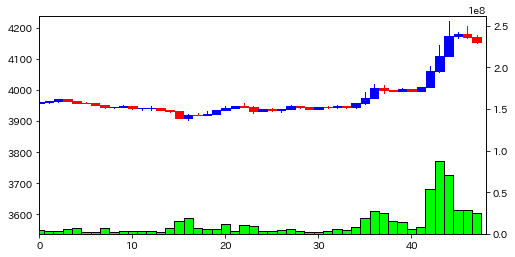

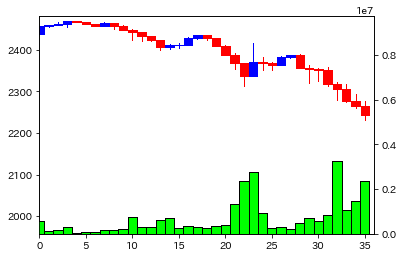

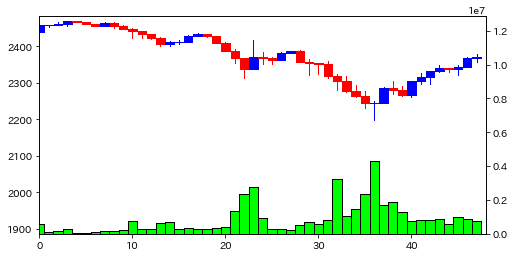

In [35]:
for i in range(1,10):
    plot_comp(alpha2[i-1:i])